# Integrating the Anisotropic Ginzburg-Landau Equation using Physics-Informed Neural Networks

Este notebook busca ser más que nada un proof of concept. Para correrlo es recomendable crear un entorno virtual (con python -m venv .venv), activarlo con source .venv/bin/activate y luego instalar las dependencias con pip install -r requirements.txt (asumiendo que lo llama desde el mismo directorio). De lo contrario puede que se instalen un montón de cosas en el ambiente global de python que no es lo ideal y podrían haber choques con las versiones.

## La ecuación en sí:

Antes de meterme con la ecuación forzada anisotrópica, veamos si es posible integrar esta ecuación:

$$
\partial_t A = \mu A + \nabla^2 A - A |A|^2
$$

Esta es la ecuación de Ginzburg-Landau compleja de toda la vida.


In [1]:
# import torch
# if torch.mps.is_available():
#     torch.set_default_device("mps")

In [2]:
# Numpy y matplotlib, junto con seaborn, para gráficos un poco mejores
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Presentar información de manera ordenada
import pandas as pd

# Librería con la magia pues
import deepxde as dde

# # PyTorch y módulos que podrían ser útiles
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

# Seed a elección
# torch.manual_seed(115)

# # Utilidades matemáticas
# import math
# from scipy.special import roots_legendre  # Aproximar intergales

# # Animaciones
# from matplotlib.animation import FuncAnimation
# import matplotlib.animation as animation
# from IPython.display import Video, display

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
# Creo algunos dominios:f

x_lower = -5
x_upper = 5

y_lower = -5
y_upper = 5

t_lower = 0
t_upper = 1.0

# Space and time domains/geometry (for the deepxde model)
space_domain = dde.geometry.Rectangle([x_lower, y_lower], [x_upper, y_upper])
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

In [4]:
# Definimos nuestra función de pérdida:

def ginzburg_landau(xy, u):
    """
    Calcula la desviación de la ecuación de Ginzburg-Landau compleja para una función u en un dominio xy.

    Parámetros:
    - xy: array de tamaño (n, 3) que representa las coordenadas (x, y, t) de los puntos en el dominio.
    - u: array de tamaño (n, 2) que representa los valores de la parte real e imaginaria de la función u en el dominio.

    Retorna:
    - Array de tamaño (n, 1), que da cuenta de la desviación de cumplir la ecuación de Ginzburg-Landau en cada punto de xy.
    """
    real_u = u[:, 0:1]
    imag_u = u[:, 1:2]
    
    # Derivadas de u
    real_u_t = dde.grad.jacobian(u, xy, i=0, j=2)
    imag_u_t = dde.grad.jacobian(u, xy, i=1, j=2) # El índice i para esta fun es el índice del input al que se le calcula el gradiente. El índice j indica la componente del gradiente.
    
    real_u_xx = dde.grad.hessian(u, xy, component=0, i=0, j=0)
    imag_u_xx = dde.grad.hessian(u, xy, component=1, i=0, j=0)
    real_u_yy = dde.grad.hessian(u, xy, component=0, i=1, j=1)
    imag_u_yy = dde.grad.hessian(u, xy, component=1, i=1, j=1)

    real_error = real_u_t - real_u - real_u_xx - real_u_yy + real_u * (real_u**2 + imag_u**2) # fijo mu = 1 porque no sé pasarle parámetros a la función de pérdida y lo otro puede ser computacionalmente costoso.
    imag_error = imag_u_t - imag_u - imag_u_xx - imag_u_yy + imag_u * (real_u**2 + imag_u**2)
    return [real_error, imag_error]

In [5]:
# Condiciones Iniciales y de borde mediante transform:

# Primero la ondición inicial:
def init_cond_u(xy):
    return xy[:, 0]

def init_cond_v(xy):
    return xy[:, 1]

def transform(xyt, pretransform_out):
    return xyt[:, :2] + xyt[:, 2:3] * pretransform_out # esto me asegura que la condición inicial se cumpla.


In [6]:
data = dde.data.TimePDE(
    geomtime,
    ginzburg_landau,
    [], # Aquí van las condiciones de borde, pero yo no sé bien cual poner así que las dejo vacías. La inicial la pongo en el transform.
    num_domain=1_000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)


# Network architecture
net = dde.nn.FNN([3] + [100] * 3 + [2], "tanh", "Glorot normal")
net.apply_output_transform(transform)

model = dde.Model(data, net)

In [ ]:
# Es recomendado utilizar aceleraciéno con GPU, es más fácil si es una GPU de NVIDIA lamentablemente.

model.compile("adam", lr=1e-3, loss="MSE")
model.train(iterations=10_000, display_every=100)

Compiling model...
'compile' took 0.750551 s

Training model...

Step      Train loss              Test loss               Test metric
0         [6.50e+03, 5.80e+03]    [6.50e+03, 5.80e+03]    []  
100       [1.05e+03, 1.00e+03]    [1.05e+03, 1.00e+03]    []  
200       [9.16e+02, 8.58e+02]    [9.16e+02, 8.58e+02]    []  
300       [7.95e+02, 7.27e+02]    [7.95e+02, 7.27e+02]    []  
400       [7.16e+02, 6.51e+02]    [7.16e+02, 6.51e+02]    []  
500       [6.55e+02, 5.97e+02]    [6.55e+02, 5.97e+02]    []  
600       [6.09e+02, 5.54e+02]    [6.09e+02, 5.54e+02]    []  
700       [5.71e+02, 5.17e+02]    [5.71e+02, 5.17e+02]    []  
800       [5.37e+02, 4.84e+02]    [5.37e+02, 4.84e+02]    []  
900       [5.05e+02, 4.54e+02]    [5.05e+02, 4.54e+02]    []  
1000      [4.77e+02, 4.27e+02]    [4.77e+02, 4.27e+02]    []  
1100      [4.50e+02, 4.02e+02]    [4.50e+02, 4.02e+02]    []  
1200      [4.25e+02, 3.80e+02]    [4.25e+02, 3.80e+02]    []  
1300      [4.02e+02, 3.59e+02]    [4.02e+02, 3

(<deepxde.model.LossHistory at 0x17577dc50>,
 <deepxde.model.TrainState at 0x1767aa9d0>)

In [8]:
# Further optim with L-BFGS-B
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.000964 s

Training model...

Step      Train loss              Test loss               Test metric
10000     [8.23e-01, 4.10e-01]    [8.23e-01, 4.10e-01]    []  

Best model at step 10000:
  train loss: 1.23e+00
  test loss: 1.23e+00
  test metric: []

'train' took 0.030829 s



### La red ya fue entrenada, ahora veamos si lo que tira tiene sentido:

(65536, 2)
(256, 256, 1)


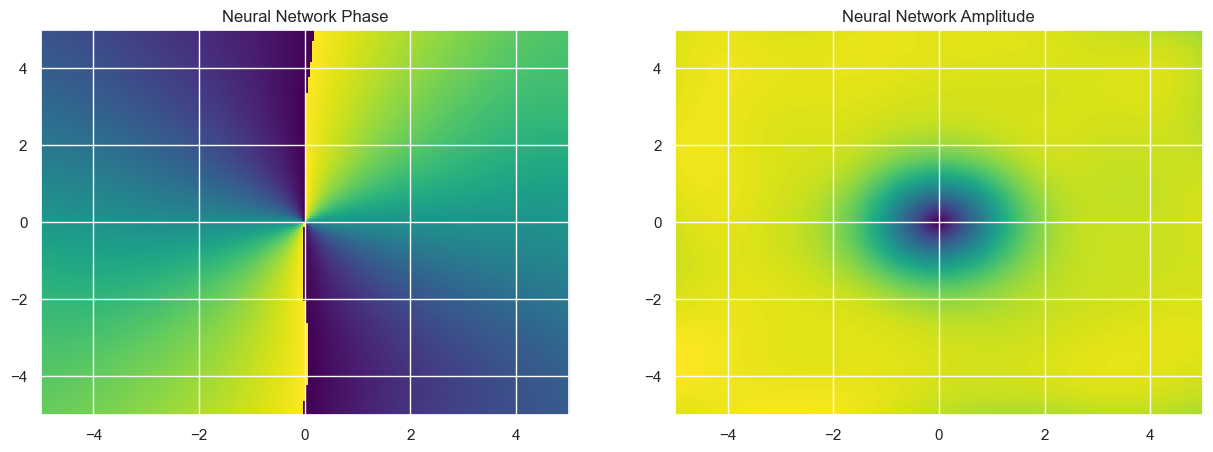

In [14]:
# Creation of the 2D domain (for plotting and input)

time_to_plot = 1.0 # forma burda de seleccionar el tiempo a plotear.

x = np.linspace(x_lower, x_upper, 256)
y = np.linspace(y_lower, y_upper, 256)
t = np.array([time_to_plot])

X, Y, T = np.meshgrid(x, y, t)

X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))
X_doublestar = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

# Predecimos:
prediction = model.predict(X_star, operator=None)
print(prediction.shape)

from scipy.interpolate import griddata

U_pred = griddata(X_doublestar, prediction[:, 0], (X, Y), method='cubic')
V_pred = griddata(X_doublestar, prediction[:, 1], (X, Y), method='cubic')

print(U_pred.shape)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].imshow(np.arctan(V_pred/U_pred), interpolation="nearest", cmap="viridis", extent=[x_lower, x_upper, y_lower, y_upper], origin="lower", aspect="auto")
ax[0].set_title('Neural Network Phase')

ax[1].imshow(np.sqrt(U_pred**2 + V_pred**2), interpolation="nearest", cmap="viridis", extent=[x_lower, x_upper, y_lower, y_upper], origin="lower", aspect="auto")
ax[1].set_title('Neural Network Amplitude')

plt.show()


### Tiene sentido ¿no?

La gran ventaja de este método es que no necesita una grilla. Para obtener más precisión, simplemente se puede agregar más datos de entrenamiento, o más pasos del algoritmo. Como esto lo estoy corriendo desde mi laptop sin acceso a mi GPU, decidí dejar este resultado con más error. Pero si se corre en una GPU, se puede obtener una precisión mucho mayor en el mismo tiempo.